In [1]:
from gensim.models import Word2Vec
from gensim.utils import tokenize
import re
from gensim.models.callbacks import CallbackAny2Vec
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA

In [2]:
class callback(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.last_loss = 0
        self.stime = time.time()

    def on_epoch_start(self, model):
        self.stime = time.time()

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        print('Loss after epoch {}: {} \t Epoch Time: {}'.format(self.epoch, loss-self.last_loss, time.time()-self.stime))
        self.last_loss = loss
        self.epoch += 1

In [3]:
sentences = []
for line in open('Turkish Corpus.tr', encoding='UTF-8'):
  sentences.append(list(tokenize(line, to_lower=True)))

In [4]:
model = Word2Vec(sentences, sg=1, min_count=5, window=7, size=100, iter=10, compute_loss=True, callbacks=[callback()])
print(len(model.wv.vocab))

Loss after epoch 0: 10992873.0 	 Epoch Time: 21.75088906288147
Loss after epoch 1: 8077323.0 	 Epoch Time: 30.665725231170654
Loss after epoch 2: 7151930.0 	 Epoch Time: 39.349472761154175
Loss after epoch 3: 7022128.0 	 Epoch Time: 49.07723093032837
Loss after epoch 4: 4263234.0 	 Epoch Time: 58.465147495269775
Loss after epoch 5: 3946644.0 	 Epoch Time: 67.56579494476318
Loss after epoch 6: 3806624.0 	 Epoch Time: 79.72032356262207
Loss after epoch 7: 3840568.0 	 Epoch Time: 92.2568244934082
Loss after epoch 8: 3713464.0 	 Epoch Time: 104.48511815071106
Loss after epoch 9: 3832876.0 	 Epoch Time: 117.04851794242859
48751


In [5]:
print("Word similarities")
words_sims = []
human_sims = []
w2v_sims = []
with open('Word Similarity.txt', 'r', encoding='UTF-8') as reader:
  for line in reader.readlines():
    try:
      w1, w2, sim, _ = re.split(':|\t|\n',line)
      print(w1, w2, sim, model.wv.similarity(w1,w2))
      w2v_sims.append(model.wv.similarity(w1,w2))
      words_sims.append((w1,w2))
      human_sims.append(float(sim))
    except:
      continue
human_sims = np.array(human_sims)
w2v_sims = np.array(w2v_sims)
w2v_sims_proj = w2v_sims*10

print()
s1 = pd.Series(human_sims)
s2 = pd.Series(w2v_sims)
print(s1.corr(s2, method='pearson'), s1.corr(s2, method='spearman'), len(words_sims))

Word similarities
saatlerce dakikalarca 6.583 0.6182829
yürüdüm koştum 6.111 0.7835391
geldiklerinde gittiklerinde 6.389 0.5526105
okudular yazdılar 5.778 0.60712576
yıllardır saatlerdir 5.139 0.2625236
yazıyorlardı okuyorlardı 5.417 0.71643674
koltuklar sandalyeler 6.417 0.8110184
bilgisayarların perdelerin 1.444 0.37147665
kedilerin kuşların 5.000 0.5896014
camları pencereleri 7.793 0.70276725
yıldızın güneşin 6.103 0.48755255
emretti buyurdu 9.069 0.5879028
yıktı yıkadı 1.690 0.32550314
yedikten içtikten 5.840 0.7008087
konuştular söylediler 8.000 0.3970453
çalıştılar yaklaştılar 2.000 0.4387237
açtılar kapattılar 6.480 0.68134683
yarasanın yasanın 1.240 0.5535815
doktorların öğretmenlerin 4.280 0.3895262
mühendisler doktorlar 4.840 0.38762647
içtiler kestiler 1.720 0.5950306
kapıların pencerelerin 5.320 0.8462132
başardı yakardı 1.400 0.37243387
ailelerin kalelerin 1.440 0.25943696
kızların erkeklerin 6.680 0.6508859
yaparken sayarken 2.440 0.3696586
derslerde sınıflarda 6.920 0.69

In [6]:
print("Word analogies")
correct_ana = []
incorrect_ana = []
with open('Analogy.txt', 'r', encoding='UTF-8') as reader:
    for line in reader.readlines():
        try:
            w11, w12, w21, w22 = line.split()
            if model.wv.vocab[w22] and model.wv.most_similar(positive=[w12, w21], negative=[w11])[0][0] == w22:
                correct_ana.append((w11, w12, w21, w22))
            else:
                incorrect_ana.append((w11, w12, w21, w22))
        except:
            continue

print(len(correct_ana)/(len(correct_ana)+len(incorrect_ana)), len(correct_ana), len(incorrect_ana))
print(correct_ana)


# aa = model.wv.evaluate_word_analogies('Analogy.txt', case_insensitive=False)
# print(aa[0], len(aa[1][0]['correct']), len(aa[1][0]['incorrect']))
# print(aa[1][0]['correct'])

Word analogies
0.07792207792207792 6 71
[('verdi', 'verdiniz', 'aldı', 'aldınız'), ('kitaplar', 'kitapların', 'gerçekler', 'gerçeklerin'), ('bir', 'birinci', 'iki', 'ikinci'), ('bir', 'birinci', 'üç', 'üçüncü'), ('giderim', 'gidersin', 'kalırım', 'kalırsın'), ('düşünürsün', 'düşünürüz', 'gidersin', 'gideriz')]


In [7]:
# https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial
def psa_word2vec_similar_plot(model, word):
    arrays = np.empty((0, model.vector_size), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
        

    Y = PCA().fit_transform(arrays)[:,:2]
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line],
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-0.5, Y[:, 0].max()+0.5)
    plt.ylim(Y[:, 1].min()-0.5, Y[:, 1].max()+0.5)
            
    plt.title('PCA similarity visualization for {}'.format(word))
    #plt.savefig("pca_sim.pdf", bbox_inches='tight')

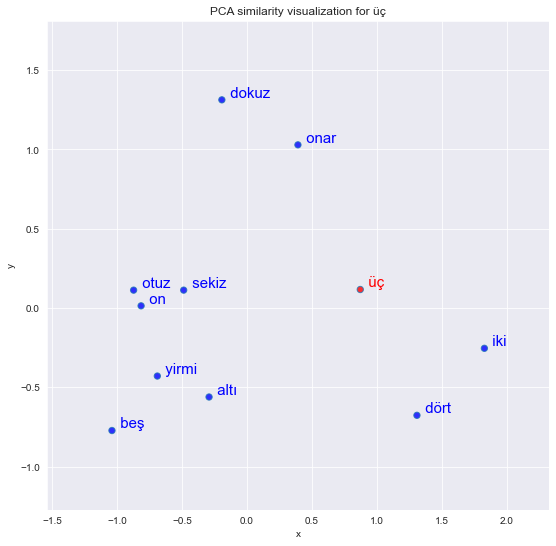

In [8]:
psa_word2vec_similar_plot(model, 'üç')

In [9]:
all_colors = ['red', 'blue', 'black', 'magenta', 'orange']

def display_pca_scatterplot(model, analogies):
    arrays = np.empty((0, model.vector_size), dtype='f')
    word_labels = []
    color_list  = []
    
    # adds the vector for each of the words from list_names to the array
#     for wrd in words:
#         wrd_vector = model.wv.__getitem__([wrd])
#         word_labels.append(wrd)
#         color_list.append('blue')
#         arrays = np.append(arrays, wrd_vector, axis=0)
        
    for cid, ana in enumerate(analogies):   
        for wrd in ana:
            wrd_vector = model.wv.__getitem__([wrd])
            word_labels.append(wrd)
            color_list.append(all_colors[cid])
            arrays = np.append(arrays, wrd_vector, axis=0)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = PCA().fit_transform(arrays)[:,:2]
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-0.5, Y[:, 0].max()+0.5)
    plt.ylim(Y[:, 1].min()-0.5, Y[:, 1].max()+0.5)
            
    plt.title('PCA visualization of Analogies')
    #plt.savefig("pca_ana.pdf", bbox_inches='tight')

In [17]:
correct_ana

[('verdi', 'verdiniz', 'aldı', 'aldınız'),
 ('kitaplar', 'kitapların', 'gerçekler', 'gerçeklerin'),
 ('bir', 'birinci', 'iki', 'ikinci'),
 ('bir', 'birinci', 'üç', 'üçüncü'),
 ('giderim', 'gidersin', 'kalırım', 'kalırsın'),
 ('düşünürsün', 'düşünürüz', 'gidersin', 'gideriz')]

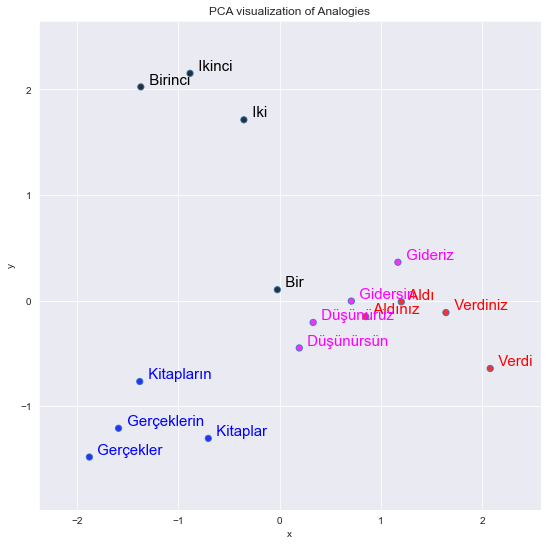

In [30]:
display_pca_scatterplot(model, [correct_ana[0],correct_ana[1],correct_ana[2],correct_ana[5]])